In [1]:
# The below code modifies the loopAnomalyCalc_ih and _gh notebooks including the subtraction of the zonal average for the model and the data.
# For now, I will just plot the height anomalies for each case of heating. 

# Add a command to produce plots directly below cells.
%matplotlib inline
# Import required packages
import numpy as np
import os
# Import xarray and glob for data analysis.
import xarray as xr
from glob import glob
# Dask for processing
import dask as da

os.chdir("/home/561/gp8431")
from climate import StandardGrid
from climate import Projection

import matplotlib.pyplot as plt

# Change working directory.
os.chdir("/scratch/w40/gp8431/run")

In [2]:
# Extract era geopotential data
files_hght = glob('/g/data/rt52/era5/pressure-levels/monthly-averaged/z/*/*')
files_hght.sort()
era_all_hght = xr.open_mfdataset(files_hght, combine='by_coords').z
era_clim_hght = era_all_hght.groupby('time.month').mean()

# Convert to geopotential height by dividing by g.
g = 9.80665
era_all_hght = era_all_hght/g
era_clim_hght = era_clim_hght/g

In [3]:
era_anom_hght = era_all_hght.sel(time=slice('2019-01-01','2019-12-31')).groupby('time.month')-era_clim_hght

era_anom_hght = era_anom_hght-era_anom_hght.mean('longitude')

era_anom_hght = era_anom_hght.rename({"latitude":"lat", "longitude":"lon", "level":"pfull"})

era_anom_hght = StandardGrid(era_anom_hght, lon_name='lon', lat_name='lat')

era_anom_oct_hght = era_anom_hght.sel(time=slice('2019-10-01','2019-10-31'))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [4]:
# Extract nh model data
os.chdir("/scratch/w40/gp8431/run/2201_constamp_0.0")
nh_hght = xr.open_dataset("plevel_daily_gh.nc", decode_times = False).hght
nh_hght_davg = nh_hght.mean('time')

In [5]:
# NOTE - no box diff in this code.

# Create empty list where srfamp values will go.
# FOR NOW, TWO EMPTY LISTS CREATED TO WORK AROUND AN ERROR!
amp_mha = []
amp_lph = []
# Create an empty list to fill with mod_temp_anom arrays for plotting.
mha_list = []
# Create an empty list to fill with lon_p arrays for plotting.
lon_p_list_h = []

fig_model = plt.figure(figsize=(16,16))

<Figure size 1152x1152 with 0 Axes>

In [6]:
# Include the anomaly in longitude in the for loop!
# Plot z200 OND

# REVIEW THIS CELL FOR HGHT ANOM IH, NH ONLY!

# Initialise an indexing variable 
i = 0

# Extract model data in a loop
for x in ["0.1", "0.2", "0.4", "0.6", "0.8", "1.0", "1.2", "1.4", "10.0"]:
#for x in ["0.0", "0.1", "1.0", "10.0"]:
    # Extract height in order to compute height anomaly

    gh_hght = xr.open_dataset("/scratch/w40/gp8431/run/gh_amp_"+x+"/plevel_daily_gh.nc", decode_times = False).hght
    # The below line is the equivalent of era_clim
    gh_hght_davg = gh_hght.mean('time')     
    
    
    mod_lat = xr.open_dataset("plevel_daily_gh.nc", decode_times = False).lat
    mod_lon = xr.open_dataset("plevel_daily_gh.nc", decode_times = False).lon
    
    # Compute height anomaly based on extracted values
    mod_anom_hght = gh_hght_davg-nh_hght_davg
    
    # Redefine the model anomaly with the zonal average removed. 
    mod_anom_hght = mod_anom_hght - mod_anom_hght.mean('lon')
    
    # Select 200 and attempt to match with era
    mod_hght_anom = mod_anom_hght.sel(pfull=200.0, lat=slice(-90.0, 30.0))
    
    #mod_temp_anom_ds = mod_temp_anom.to_dataset(name='temp')
    
    mod_hght_anom_ds = mod_hght_anom.to_dataset(name='hght')
    
    mod_hght_anom_ds['amp'] = amp_mha.append(float(x))
    mha_list.append(mod_hght_anom_ds)

    mod_hght_anom_eq = mod_anom_hght.sel(lat=0.0, method='nearest')
    mod_hght_anom_eq_ds = mod_hght_anom_eq.to_dataset(name='hght')
    mod_hght_anom_eq_ds['amp'] = amp_lph.append(float(x))
    lon_p_list_h.append(mod_hght_anom_eq_ds)


    i = i + 1

FileNotFoundError: [Errno 2] No such file or directory: b'/scratch/w40/gp8431/run/2201_constamp_0.1/plevel_daily_gh.nc'

In [ ]:
# Concatenate the lists along the dimension 'amp'.
#dt_IOD_concat = xr.concat(dt_IOD, dim='amp')
#mta_list_concat = xr.concat(mta_list, dim='amp')
#lon_p_list_concat = xr.concat(lon_p_list, dim='amp')
mha_list_concat = xr.concat(mha_list, dim='amp')
lon_p_list_h_concat = xr.concat(lon_p_list_h, dim='amp')

In [ ]:
#mta_list_concat['amp'] = amp_mta
#lon_p_list_concat['amp'] = amp_lp
mha_list_concat['amp'] = amp_mha
lon_p_list_h_concat['amp'] = amp_lph

In [ ]:
#lon_lat_plot_gh = mta_list_concat.temp.plot(x="lon", y="lat", col="amp", col_wrap=3)

In [ ]:
#lon_p_plot_gh = lon_p_list_concat.sel(pfull=slice(1000,300)).temp.plot(x="lon", y="pfull", col="amp", col_wrap=3)

In [ ]:
#lon_p_plot_gh_hght = lon_p_list_h_concat.sel(pfull=slice(1000,300)).hght.plot(x="lon", y="pfull", col="amp", col_wrap=3)

In [ ]:
lon_lat_plot_gh_hght = mha_list_concat.hght.plot(x="lon", y="lat", col="amp", col_wrap=3)

In [ ]:
fig_proj, ax, trans = Projection('PlateCarree', coast=True, kw_args={'central_longitude': 180})#fig_proj,ax = Projection()
mha_list[5].hght.squeeze().plot.contourf(ax=ax, cmap='RdBu_r', levels=21, **trans)
##ax.contourf(era_anom_lon_aug_700.lon, era_anom_lon_aug_700.lat, era_anom_lon_aug_700.squeeze().values, **trans)
#fig_proj.savefig('/home/561/gp8431/fig_era_hght_lon_coast.png')

    # Put subplots for each heating option into one plot!
    #ax_mod = fig_model.add_subplot(3, 3, i+1)
    #cax_mod = ax_mod.pcolormesh(mod_lon, mod_lat, mod_temp_anom.squeeze().values)
    #mod_temp_anom.plot(ax=ax_mod)
    #ax_mod.set(title = 'model_' + x)
    ##cbar_mod = fig_model.colorbar(cax_mod)
    #fig_model.savefig('/home/561/gp8431/fig_model.png')

In [ ]:
mha_list[5].hght.squeeze()

In [7]:
# Define a function to do the above based on heating input, temp or height extraction, pressure levels, 
# and check output of function compared to above. 
# ADD AN ARGUMENT FOR LATITUDE PLOT RANGE
# ADD A DIVISION FACTOR IF HGHT IS REQUESTED
# ADD AN ARGUMENT FOR A LIST OF SRFAMP VALUES (and adjust function to account for variable length).
def plt_mod_anom(heating, var, plev):
    # Extract nh model data
    os.chdir("/scratch/w40/gp8431/run/2201_constamp_0.0")
    
    # For example, getattr(x, 'foobar') is equivalent to x.foobar. 
    
    nh = getattr(xr.open_dataset("plevel_daily_gh.nc", decode_times = False), var)
    
    #nh = xr.open_dataset("plevel_daily_gh.nc", decode_times = False).var
    nh_avg = nh.mean('time')
    
    fig_model = plt.figure(figsize=(16,16))
    
    amp_ma = []
    #amp_lp = []
    ma_list = []
    #lon_p_list_h = []

    i = 0

    # Extract model data in a loop
    for x in ["0.1", "0.2", "0.4", "0.6", "0.8", "1.0", "1.2", "1.4", "10.0"]:
    #for x in ["0.0", "0.1", "1.0", "10.0"]:
        # Extract requested variable in order to compute anomaly.
        
        if (heating=='gh'):
            h_var = getattr(xr.open_dataset("/scratch/w40/gp8431/run/gh_amp_"+x+"/plevel_daily_gh.nc", decode_times = False), var)
        elif (heating=='ih'):
            h_var = getattr(xr.open_dataset("/scratch/w40/gp8431/run/2001_srfamp_"+x+"/plevel_daily_ih.nc", decode_times = False), var)
        
        # ADD CHECK FOR BUGS
        
        h_var_avg = h_var.mean('time')     
        print(h_var_avg)

        #mod_lat = xr.open_dataset("plevel_daily_gh.nc", decode_times = False).lat
        #mod_lon = xr.open_dataset("plevel_daily_gh.nc", decode_times = False).lon

        # Compute height anomaly based on extracted values
        mod_anom_var = h_var_avg-nh_avg

        # Redefine the model anomaly with the zonal average removed. 
        mod_anom_var = mod_anom_var - mod_anom_var.mean('lon')

        # Select 200 and attempt to match with era
        mod_anom_var = mod_anom_var.sel(pfull=plev, lat=slice(-90.0, 30.0))

        #mod_temp_anom_ds = mod_temp_anom.to_dataset(name='temp')

        mod_anom_var_ds = mod_anom_var.to_dataset(name=var)

        mod_anom_var_ds['amp'] = amp_ma.append(float(x))
        ma_list.append(mod_anom_var_ds)

        #mod_hght_anom_eq = mod_anom_hght.sel(lat=0.0, method='nearest')
        #mod_hght_anom_eq_ds = mod_hght_anom_eq.to_dataset(name='hght')
        #mod_hght_anom_eq_ds['amp'] = amp_lph.append(float(x))
        #lon_p_list_h.append(mod_hght_anom_eq_ds)


        i = i + 1
        
    
    ma_list_concat = xr.concat(ma_list, dim='amp')
    #lon_p_list_h_concat = xr.concat(lon_p_list_h, dim='amp')
    ma_list_concat['amp'] = amp_ma
    #lon_p_list_h_concat['amp'] = amp_lph
    
    test = getattr(ma_list_concat, var)
    
    fig_model = test.plot(x="lon", y="lat", col="amp", col_wrap=3)
    
    
    return fig_model

<xarray.DataArray 'hght' (pfull: 17, lat: 64, lon: 128)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[  627.6953 ,   627.65894,   627.623  , ...,   627.8062 ,
           627.76965,   627.7325 ],
        [  626.386  ,   626.24066,   626.09644, ...,   627.2029 ,
           627.05585,   626.9063 ],
        [  623.53217,   623.51776,   622.8047 , ...,   624.6225 ,
           624.2714 ,   623.9069 ],
...
      

AttributeError: 'FacetGrid' object has no attribute 'savefig'

<Figure size 1152x1152 with 0 Axes>

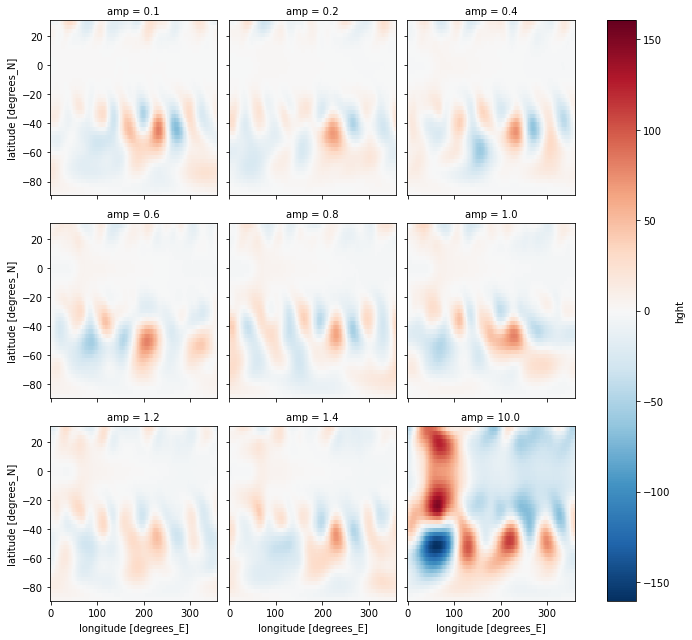

In [8]:
gh_hght_200 = plt_mod_anom('gh', 'hght', 200)
# Figure out how to save facet grid figure and add projections to it!
gh_hght_200.savefig('/home/561/gp8431/gh_hght_200.png')